## Predicting Beer Reviews
> Griffin Davis and Sydnee Haney

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen, HTTPError
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import LabelEncoder, StandardScaler


#### Load in Data

In [342]:
fr = None
try:
    fr = open('../Datasets/beer_ratings.json', 'r')
except FileNotFoundError:
    try:
        fr = urlopen(
            'https://raw.githubusercontent.com/davisgriffin/Machine_Learning/main/Datasets/beer_ratings.json')
    except HTTPError:
        raise Exception('Cannot read data')
beer_ratings = pd.read_json(fr, orient='records')
fr.close()

#### Create Dataframes

In [343]:
X = beer_ratings[['beer/ABV', 'user/ageInSeconds',
                  'user/gender', 'review/timeStruct', 'beer/style', 'review/overall']].copy()

# Convert timeStruct of form {'mday': 22, 'mon': 11} to 1122
X['review/timeStruct'] = [int("{}{}".format(*(timeStruct['mon'], timeStruct['mday'])))
    for timeStruct in X['review/timeStruct']]
    
X = X.dropna()
y = X['review/overall']
X.drop(columns='review/overall', inplace=True)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X

,beer/ABV,user/ageInSeconds,review/timeStruct,user/gender_Female,user/gender_Male,beer/style_Altbier,beer/style_American Adjunct Lager,beer/style_American Amber / Red Ale,beer/style_American Amber / Red Lager,beer/style_American Barleywine,...,beer/style_Schwarzbier,beer/style_Scotch Ale / Wee Heavy,beer/style_Scottish Ale,beer/style_Scottish Gruit / Ancient Herbed Ale,beer/style_Smoked Beer,beer/style_Tripel,beer/style_Vienna Lager,beer/style_Wheatwine,beer/style_Winter Warmer,beer/style_Witbier
4,7.7,3.581417e+09,1230,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,5.6,1.782054e+09,831,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,7.4,9.833726e+08,111,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,7.4,1.263823e+09,1010,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,7.4,8.931710e+08,83,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49947,9.0,1.031667e+09,318,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49951,9.0,1.284822e+09,38,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49956,9.0,8.941214e+08,226,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49964,9.0,9.497594e+08,25,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create Linear Model

In [344]:
lin = LinearRegression().fit(X_train, y_train)
lin_prediction = lin.predict(X_test)
score = lin.score(X_test, y_test)
print('''R^2: {:.4f}
Mean Absolute Percentage Error: {:.4f}%'''.format(score, MAPE(y_test, lin_prediction)*100))

R^2: 0.1814
Mean Absolute Percentage Error: 14.6062%


#### Create Logistic Dataframes

In [345]:
# Encode and Scale values
le = LabelEncoder()
scaler = StandardScaler()

# create multiclass labels to replace floats
X_log = X.copy().apply(le.fit_transform)
le.fit(y)
y_log = le.transform(y.copy()) # separate fit and transform to invert later

# scale data for convergence
X_log = scaler.fit_transform(X_log)

X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, shuffle=True)

#### Create Logistic Model

In [346]:
log = LogisticRegression(tol=5e-1, max_iter=100).fit(X_train, y_train)
log_prediction = log.predict(X_test)
score = log.score(X_test, y_test)

# transform multiclass labels back to 5-star rating
log_prediction = le.inverse_transform(log_prediction)
y_test = le.inverse_transform(y_test)

print('''R^2: {:.4f}
Mean Absolute Percentage Error: {:.4f}%'''.format(score, MAPE(y_test, log_prediction)*100))

R^2: 0.3891
Mean Absolute Percentage Error: 13.9881%


#### Visualizing Predictions

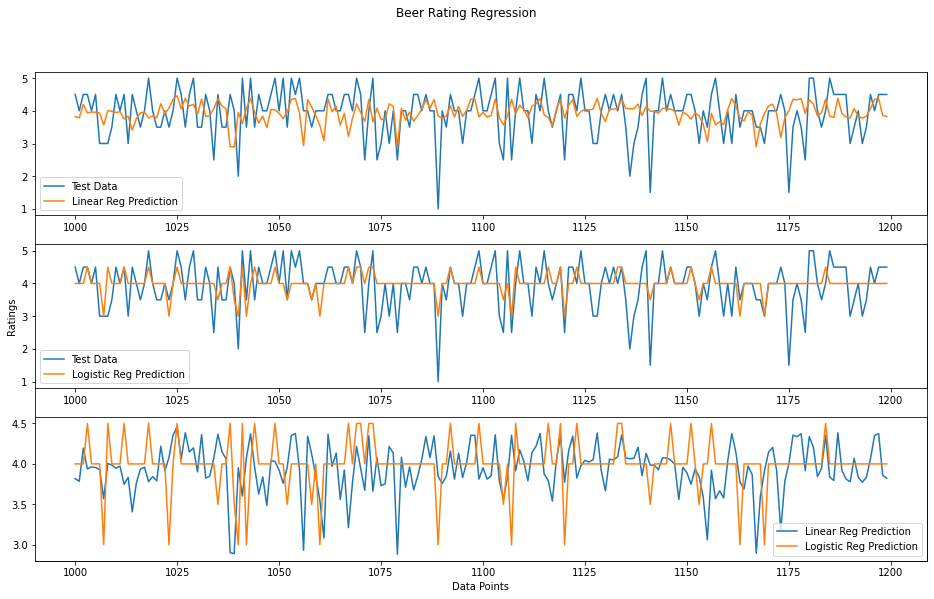

In [347]:
data_min = 1000
data_max = 1200

plt.close('all')
x = np.arange(0, len(lin_prediction))
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False
)

ax3.set_xlabel('Data Points')
ax2.set_ylabel('Ratings')
fig.suptitle('Beer Rating Regression')

ax1.plot(x[data_min:data_max], y_test[data_min:data_max], label='Test Data')
ax2.plot(x[data_min:data_max], y_test[data_min:data_max], label='Test Data')

ax1.plot(x[data_min:data_max], lin_prediction[data_min:data_max], label='Linear Reg Prediction')
ax3.plot(x[data_min:data_max], lin_prediction[data_min:data_max], label='Linear Reg Prediction')

ax2.plot(x[data_min:data_max], log_prediction[data_min:data_max], label='Logistic Reg Prediction')
ax3.plot(x[data_min:data_max], log_prediction[data_min:data_max], label='Logistic Reg Prediction')

ax1.legend()
ax2.legend()
ax3.legend()

fig.set_size_inches(16, 9, forward=True)
plt.show()